In [3]:

import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import List
import tqdm
import mnist_reader
%load_ext autoreload
%autoreload

In [4]:
def create_dataset(digits = [1,7], noise_std = 0, random_transpose = False):
  mnist = scipy.io.loadmat("mnist-original.mat")
 
  mnist_xs, mnist_ys = mnist["data"], mnist["label"]
  mnist_xs = mnist_xs.T
  mnist_ys = mnist_ys.squeeze()

  #mnist_xs = ((mnist_xs.astype(float)/255) - 0.1307)/0.3081
  mnist_xs = mnist_xs.astype(float)/255
  noise = np.random.normal(0,noise_std, size = mnist_xs.shape)
  mnist_xs += noise

  zipped = list(zip( mnist_xs, mnist_ys))
  random.shuffle(zipped)
  mnist_xs, mnist_ys = np.array([x for (x,y) in zipped if y in digits]), np.array([y for (x,y) in zipped if y in digits])
  if random_transpose:
    
    for i,x in enumerate(mnist_xs):
        
        if np.random.random() < 0.5:
            mnist_xs[i] = x.reshape(28,28).T.reshape(-1)

  l = int(0.8  * len(mnist_xs))
  train = list(zip(mnist_xs[:l], mnist_ys[:l]))
  dev = list(zip(mnist_xs[l:], mnist_ys[l:]))

  X_train = np.array([x for x,y in train])
  Y_train = np.array([y for x,y in train])
  X_dev = np.array([x for x,y in dev])
  Y_dev = np.array([y for x,y in dev])

  return (X_train, Y_train), (X_dev, Y_dev)

def show_some_images(images, n = 3):
  
  for index, image in enumerate(images[:n]):
    plt.imshow(image.reshape(28,28),cmap='gray')
    #plt.imshow(np.moveaxis(image, 0, -1))
    plt.show()
    


def tsne(vecs, labels, title="", words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["digit={}".format(int(i)) for i in labels.tolist()]
  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3)
  plt.legend()
  plt.title(title)
    

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k, random_state = 0)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

In [423]:
(X_train_dev, Y_train_dev) = mnist_reader.load_mnist('data/fashion-mnist', kind='train')
label2cloth = {0: "t-shirt", 1: "trouser", 2: "pullover", 3: "dress", 4: "coat", 5: "sandal", 6: "shirt", 7: "sneaker", 8: "bag", 9: "boot"}
cloth2label = {l:i for i,l in label2cloth.items()}
TO_KEEP = ["shirt", "coat"]

X_train_dev, Y_train_dev = np.array([x for x,y in zip(X_train_dev, Y_train_dev) if label2cloth[y] in TO_KEEP]),np.array([y for x,y in zip(X_train_dev, Y_train_dev) if label2cloth[y] in TO_KEEP])
X_train_dev = X_train_dev.astype(float)/255.
l = int(0.8 * len(X_train_dev))
X_train, Y_train = X_train_dev[:l], Y_train_dev[:l]
X_dev, Y_dev = X_train_dev[l:], Y_train_dev[l:]

noise = np.random.normal(0, 0.25, size = X_train.shape)
X_train = X_train + noise

In [424]:
max(X_train[0])

1.3366334393908073

In [425]:
#(X_train, Y_train), (X_dev, Y_dev) = create_dataset(digits = [6,7], noise_std = 0.0, random_transpose = True)

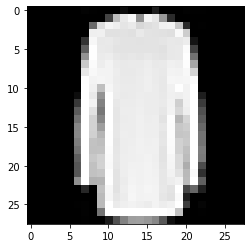

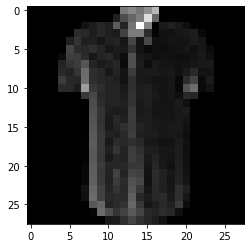

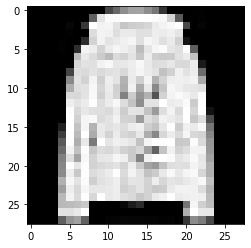

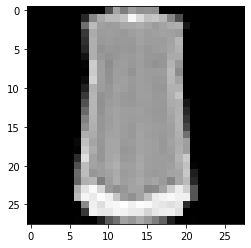

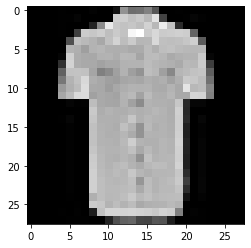

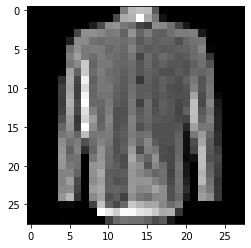

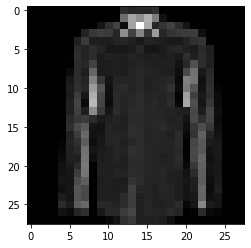

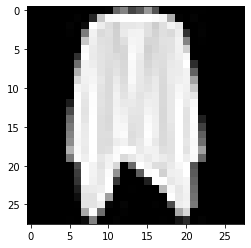

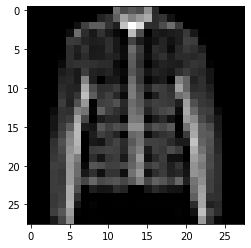

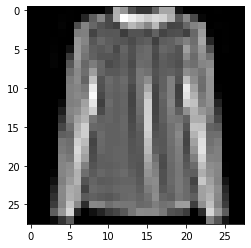

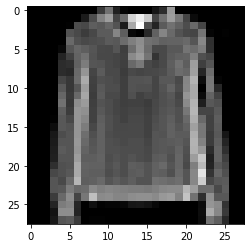

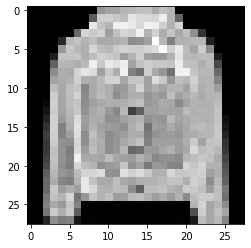

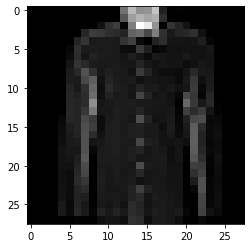

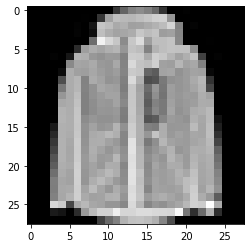

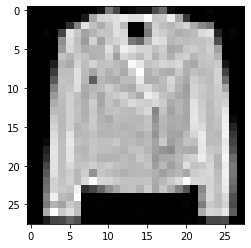

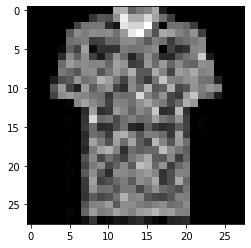

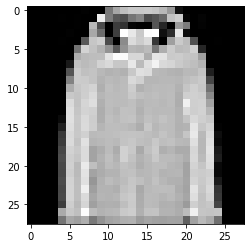

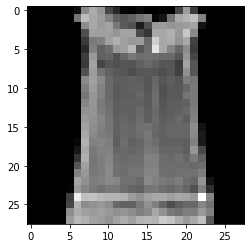

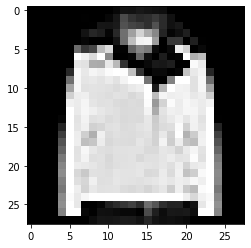

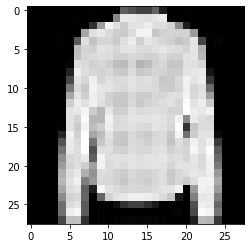

In [428]:
show_some_images(X_dev, n = 20)

### Perform PCA

In [429]:
pca = PCA(n_components=784)
pca.fit(X_train)
dev_projected = pca.transform(X_dev)
mu = np.mean(X_dev, axis = 0)
nComp = 25
Xhat_pca = np.dot(pca.transform(X_dev)[:,:nComp], pca.components_[:nComp,:])
Xhat_pca += mu

### Perform INLP

In [430]:
clf = SGDClassifier
params = {"n_jobs": 8, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 15000, 'tol': 0.05*1e-3}#, 'tol': 0.5 * 1e-4}

#clf = LinearSVC
#params = {'dual': False}
autoregressive = True
dropout = 0
n = 30
P, rowspace_projections, Ws = inlp.run_inlp(clf, params, n, 784, autoregressive, min_accuracy = 0.0, X_train=X_train,
                                            Y_train=Y_train, X_dev=X_dev, Y_dev=Y_dev, dropout_rate = dropout)









  0%|          | 0/30 [00:00<?, ?it/s]







iteration: 0, accuracy: 0.8616666666666667:   0%|          | 0/30 [00:01<?, ?it/s]







iteration: 0, accuracy: 0.8616666666666667:   3%|▎         | 1/30 [00:01<00:49,  1.71s/it]







iteration: 1, accuracy: 0.8179166666666666:   3%|▎         | 1/30 [00:03<00:49,  1.71s/it]







iteration: 1, accuracy: 0.8179166666666666:   7%|▋         | 2/30 [00:03<00:47,  1.69s/it]







iteration: 2, accuracy: 0.7804166666666666:   7%|▋         | 2/30 [00:05<00:47,  1.69s/it]







iteration: 2, accuracy: 0.7804166666666666:  10%|█         | 3/30 [00:05<00:50,  1.86s/it]







iteration: 3, accuracy: 0.725:  10%|█         | 3/30 [00:07<00:50,  1.86s/it]             







iteration: 3, accuracy: 0.725:  13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]







iteration: 4, accuracy: 0.7383333333333333:  13%|█▎        | 4/30 [00:09<00:50,  1.93s/it]







iteration: 4, accuracy: 0.7383333333333333:  17%|█▋        | 5/30 [00:09<00:46,  1.87

In [431]:
nComp = 25
Xhat_inlp = np.zeros_like(X_dev)
for P in rowspace_projections[:nComp]:
    Xhat_inlp =  Xhat + P.dot(X_dev.T).T
#show_some_images(Xhat, n = 10)

## Perform T-sne on the images, reconstructed from 25 dimensions

764
736


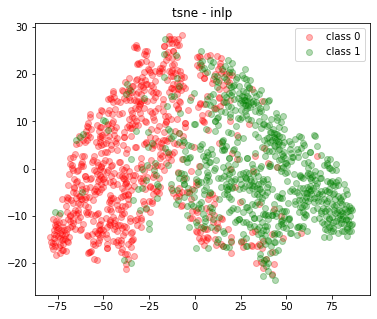

In [432]:
tsne(Xhat_inlp[:1500], Y_dev[:1500], "tsne - inlp")

764
736


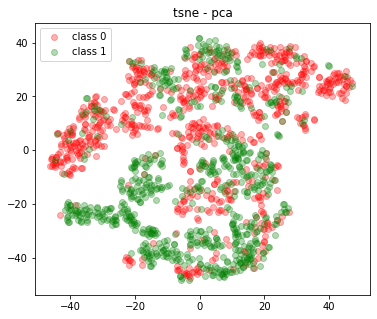

In [433]:
tsne(Xhat_pca[:1500], Y_dev[:1500], "tsne - pca")

## Compute V-measure - to quantify class seperation after dim reduction

In [434]:
print(compute_v_measure(X_dev, Y_dev, k = 2))
print(compute_v_measure(Xhat_pca, Y_dev, k = 2))
print(compute_v_measure(Xhat_inlp, Y_dev, k = 2))

0.0521627120451652
0.052526879066804484
0.3876432828887173


In [435]:
def get_pca_projection(pca, data, dim):
    
    data_projected = pca.transform(data)
    mean = np.mean(data, axis = 0)
    Xhat_pca = np.dot(data_projected[:,:dim], pca.components_[:dim,:])
    Xhat_pca += mu
    
    return Xhat_pca

def get_inlp_projection(inlp_rowspace_projections: List[np.ndarray], data, dim):

    Xhat = np.zeros_like(data)
    for P in inlp_rowspace_projections[:dim]:
        Xhat = Xhat + P.dot(data.T).T
    
    return Xhat

def plot_Vmeasure_by_dim(pca, inlp_rowspace_projections, data_x, data_y, max_dim = 20):
    
    dims = range(1, max_dim + 1)
    pca_v_measures = []
    inlp_v_measures = []
    
    for dim in tqdm.tqdm(dims, ascii = True, total = len(dims)):
        
        pca_proj = get_pca_projection(pca, data_x, dim)
        inlp_proj = get_inlp_projection(inlp_rowspace_projections, data_x, dim)
        
        pca_v_measure = compute_v_measure(pca_proj, data_y, k = len(set(data_y.tolist())))
        inlp_v_measure = compute_v_measure(inlp_proj, data_y, k = len(set(data_y.tolist())))
        pca_v_measures.append(pca_v_measure)
        inlp_v_measures.append(inlp_v_measure)
    
    plt.plot(dims, pca_v_measures, label = "pca", color = "blue")
    plt.plot(dims, inlp_v_measures, label = "inlp", color = "red")
    plt.legend()
    plt.ylabel("V-measure")
    plt.xlabel("dim")
    plt.ylim([0,1])
    plt.title("V-measure vs. number of components")
    plt.show()









  0%|          | 0/20 [00:00<?, ?it/s]







  5%|5         | 1/20 [00:00<00:13,  1.42it/s]







 10%|#         | 2/20 [00:01<00:13,  1.38it/s]







 15%|#5        | 3/20 [00:02<00:12,  1.33it/s]







 20%|##        | 4/20 [00:03<00:12,  1.24it/s]







 25%|##5       | 5/20 [00:04<00:12,  1.20it/s]







 30%|###       | 6/20 [00:05<00:12,  1.15it/s]







 35%|###5      | 7/20 [00:06<00:11,  1.09it/s]







 40%|####      | 8/20 [00:07<00:11,  1.06it/s]







 45%|####5     | 9/20 [00:08<00:10,  1.02it/s]







 50%|#####     | 10/20 [00:09<00:09,  1.00it/s]







 55%|#####5    | 11/20 [00:10<00:09,  1.04s/it]







 60%|######    | 12/20 [00:11<00:08,  1.05s/it]







 65%|######5   | 13/20 [00:12<00:07,  1.08s/it]







 70%|#######   | 14/20 [00:13<00:06,  1.11s/it]







 75%|#######5  | 15/20 [00:14<00:05,  1.13s/it]







 80%|########  | 16/20 [00:16<00:04,  1.16s/it]







 85%|########5 | 17/20 [00:17<00:03,  1.19s/it]







 90%|######### | 18/

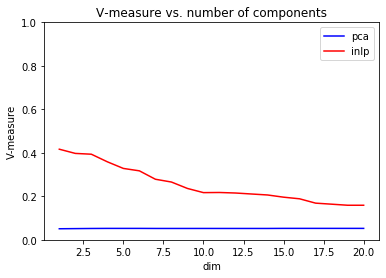

In [436]:
plot_Vmeasure_by_dim(pca, rowspace_projections, X_dev, Y_dev, max_dim = 20)

## plot the reconstructed images

In [437]:
def plot(original_images, pca_images, inlp_images):
    
    fig, axs = plt.subplots(len(pca_images), 2, figsize=(5,100))
    axs[0,0].set_title("PCA")
    axs[0,1].set_title("INLP")
    #axs.set_axis_off()
    #for i, original_img in enumerate(pca_images):
    #    axs[i,0].imshow(original_img.reshape(28,28),cmap='gray')
        
    for i, pca_img in enumerate(pca_images):
        axs[i,0].imshow(pca_img.reshape(28,28),cmap='gray')
    for i, inlp_img in enumerate(inlp_images):
        axs[i,1].imshow(inlp_img.reshape(28,28),cmap='gray')
    plt.show()

In [438]:
k = 30
inlp_imgs = get_inlp_projection(rowspace_projections, X_dev[:k], 20)
pca_imgs = get_pca_projection(pca, X_dev[:k], 20)

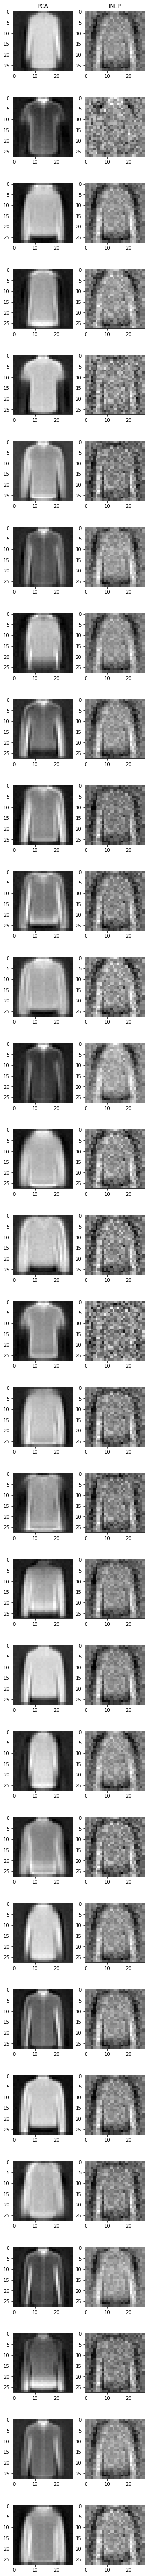

In [439]:
plot(X_dev[:k], pca_imgs, inlp_imgs)